# Coursera Captone Project: Effects of Public Transportation on Businesses

In this notebook, I will analyze location data in the greater Boston area, using the Foursquare API.  Specifically, I will examine the distances between venues and public transportation, then see how this distance correlates with various success metrics, such as ratings and number of likes.  In this way, we can determine which types of businesses are most dependent on public transportation for success.  This information will provide important guidance for people starting businesses, who need to know whether distance to public tranportation is a critical factor in picking a location.

We begin by importing all the necessary libraries, as well as defining the relevant client information for Foursquare API calls.

In [27]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import geopy.distance
import math
import requests
import folium
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

CLIENT_ID = '1IEN4PLSOERI14U34SSJWBW3Y50KNRC5UW0VK1EQET3BCSBO'
CLIENT_SECRET = 'FFVMJ1FBHJT23EJ3VIUSB4JVENPWP1IZ1NQKZOUQQ5JQB02G'
VERSION = '20180605'
TRANSID = '4bf58dd8d48988d1fd931735'     # Foursquare category id for metro stations
CITY_RADIUS = 3000     # We consider only the dense urban core, within 3km of the city center
STATION_RADIUS = 1000     # We will look at venues within 1km of each station (eliminating overlaps as necessary)
CITY_LIMIT = 30       # There are approximately 30 unique metro stops in the center city.
STATION_LIMIT = 20       # We will take the top 20 venues around each station

We use Nominatim to obtain the latitude and longitude of Boston.

In [19]:
geolocator = Nominatim(user_agent = 'boston_transit_explorer')
location = geolocator.geocode('Boston, MA')
boslat = location.latitude
boslng = location.longitude

Using Foursquare, we obtain a dataframe (boston_metro) containing the latitude and longitude of all metro stations within 3km of the city center.

In [20]:
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, TRANSID, boslat, boslng, 3000, CITY_LIMIT)
results = requests.get(url).json()["response"]['venues']

metro_list = []
metro_list.append([(v['name'], v['location']['lat'], 
        v['location']['lng']) for v in results])
boston_metro = pd.DataFrame(metro_list[0])
boston_metro.columns=['Station', 'Latitude', 'Longitude']
print('Total number of metro stations: ' + str(len(boston_metro)))
boston_metro.head()

Total number of metro stations: 30


,Station,Latitude,Longitude
0,MBTA Government Center Station,42.359605,-71.059440
1,MBTA North Station,42.366242,-71.062338
2,South Station Terminal (MBTA / Amtrak),42.352109,-71.055177
3,MBTA Downtown Crossing Station,42.355368,-71.060215
4,MBTA Park Street Station,42.356324,-71.062543


We visualize the locations of all metro stations using Folium.

In [21]:
metro_map = folium.Map(location=[boslat, boslng], zoom_start=13)

for lat, lon, poi in zip(boston_metro['Latitude'], boston_metro['Longitude'], boston_metro['Station']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(metro_map)
       
metro_map

We obtain the top 20 venues within 1km of each station, stored in the dataframe boston_venues.  (Duplicates will be deleted later.)

In [22]:
venue_list = []
for name, lat, lng in zip(boston_metro['Station'], boston_metro['Latitude'], boston_metro['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, STATION_RADIUS, STATION_LIMIT)
    results = requests.get(url).json()["response"]['groups'][0]['items']
    venue_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], 
        v['venue']['location']['lng'], v['venue']['categories'][0]['name'], v['venue']['id']) for v in results])
    
boston_venues = pd.DataFrame([item for v in venue_list for item in v])
boston_venues.columns = ['Station', 'Station Latitude', 'Station Longitude', 'Venue', 
                  'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Venue ID']
boston_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,MBTA Government Center Station,42.359605,-71.05944,Tatte Bakery & Cafe,42.358451,-71.057981,Bakery,5c95073698fbfc002c2847c1
1,MBTA Government Center Station,42.359605,-71.05944,Ruth's Chris Steak House,42.358125,-71.059337,Steakhouse,525da4dd498eb92d634abc6f
2,MBTA Government Center Station,42.359605,-71.05944,sweetgreen,42.357704,-71.058713,Salad Place,572b7990498e53c1a5b9b2d2
3,MBTA Government Center Station,42.359605,-71.05944,haley.henry,42.357574,-71.059495,Restaurant,57a50fbc498e6c05045175fa
4,MBTA Government Center Station,42.359605,-71.05944,Zo,42.359303,-71.060352,Greek Restaurant,4b4f6a57f964a520930527e3


We calculate the distance from each venue to the closest metro station.  We drop duplicate entries, making sure to keep the smallest distance to a station.

In [23]:
dist = []
for i in range(0, len(boston_venues)):
    dist.append(geopy.distance.geodesic((boston_venues['Venue Latitude'][i], boston_venues['Venue Longitude'][i]),
                                                               (boston_venues['Station Latitude'][i], boston_venues['Station Longitude'][i])).m)
boston_venues['Distance to Station'] = dist

boston_venues.sort_values(by=['Station','Distance to Station'])
boston_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'], keep='first',inplace=True)
boston_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Distance to Station
0,MBTA Government Center Station,42.359605,-71.05944,Tatte Bakery & Cafe,42.358451,-71.057981,Bakery,5c95073698fbfc002c2847c1,175.796402
1,MBTA Government Center Station,42.359605,-71.05944,Ruth's Chris Steak House,42.358125,-71.059337,Steakhouse,525da4dd498eb92d634abc6f,164.658024
2,MBTA Government Center Station,42.359605,-71.05944,sweetgreen,42.357704,-71.058713,Salad Place,572b7990498e53c1a5b9b2d2,219.577712
3,MBTA Government Center Station,42.359605,-71.05944,haley.henry,42.357574,-71.059495,Restaurant,57a50fbc498e6c05045175fa,225.732027
4,MBTA Government Center Station,42.359605,-71.05944,Zo,42.359303,-71.060352,Greek Restaurant,4b4f6a57f964a520930527e3,82.318921


We visualize all the venues, along with their corresponding closest metro station.  With a few exceptions, we see that top venues are typically clustered fairly close to the metro stations.

In [24]:
for lat, lon, poi in zip(boston_venues['Venue Latitude'], boston_venues['Venue Longitude'], boston_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(metro_map)
       
metro_map

We create a histogram of distances to the nearest metro station, and we see that the majority of top venues tend to be clustered around 100-300 meters from stations.

Text(0, 0.5, 'Number of Venues')

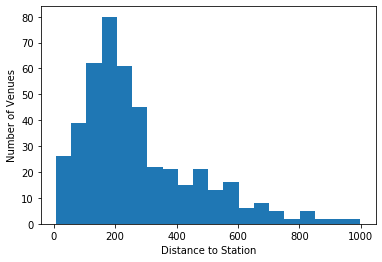

In [157]:
BIN_COUNT = 20

counts = plt.hist(boston_venues['Distance to Station'],bins=BIN_COUNT)[0]
plt.xlabel('Distance to Station')
plt.ylabel('Number of Venues')

To be more precise, we should really look at the density of top venues as a function of distance, since the area per bin increases as a function of distance.  Below, we plot the density of top venues (per square km) as a function of distance, which we see decreases very quickly.  Indeed, we plot the logarithm of density versus distance, which turns out to be a nice linear plot (R-square = 0.97).  This indicates that the density of venues decreases exponentially as a function of distance.  This is already a strong indicator that businesses should try to be located as close as possible to metro stations.

R-square value is: 0.9727215934126182


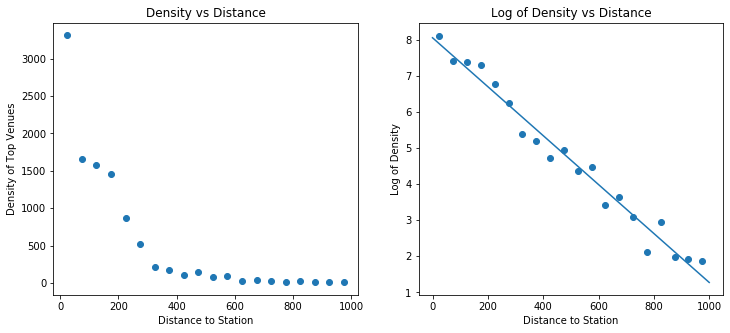

In [158]:
density = []
avg_dist = []
for i in range(0,BIN_COUNT):
    density.append(counts[i]*(BIN_COUNT**2)/(np.pi*((2*i) + 1)))  # Calculates number of venues per square km in bin
    avg_dist.append((1000/(2*BIN_COUNT)) + ((1000/BIN_COUNT)*i))

df = pd.DataFrame({'density': density, 'avg_dist': avg_dist})
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))   
ax1.scatter(avg_dist,density)
ax2.scatter(avg_dist,np.log(density))
ax1.set_xlabel('Distance to Station')
ax2.set_xlabel('Distance to Station')
ax1.set_ylabel('Density of Top Venues')
ax2.set_ylabel('Log of Density')
ax1.set_title('Density vs Distance')
ax2.set_title('Log of Density vs Distance')

LR = LinearRegression()
LR.fit(df[['avg_dist']],np.log(df[['density']]))
x = np.linspace(0,1000,100)
ax2.plot(x, LR.coef_[0] * x + LR.intercept_[0])
print('R-square value is: ' + str(LR.score(df[['avg_dist']],np.log(df[['density']]))))

To make a more detailed study of the quality of venues versus distance from a metro stop, we must access ratings data via a separate set of Foursquare API calls.  (After the first run, data is saved to the file 'ratings.csv', then loaded as needed in subsequent use of the notebook.)

In [11]:
#rating = []
#likes = []
#for id in boston_venues['Venue ID']:
#    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
#        id, CLIENT_ID, CLIENT_SECRET, VERSION)
#    results = requests.get(url).json()['response']['venue']
#    rating.append(results['rating'])
#    likes.append(results['likes']['count'])
#    
#boston_venues['Rating'] = rating
#boston_venues['Likes'] = likes
#boston_venues.to_csv('ratings.csv')

In [12]:
boston_venues = pd.read_csv('ratings.csv')
boston_venues.head()

,Unnamed: 0,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Distance to Station,Rating,Likes
0,0,MBTA Government Center Station,42.359605,-71.05944,Tatte Bakery & Cafe,42.358451,-71.057981,Bakery,5c95073698fbfc002c2847c1,175.796402,9.0,32
1,1,MBTA Government Center Station,42.359605,-71.05944,sweetgreen,42.357704,-71.058713,Salad Place,572b7990498e53c1a5b9b2d2,219.577712,8.8,83
2,2,MBTA Government Center Station,42.359605,-71.05944,haley.henry,42.357574,-71.059495,Restaurant,57a50fbc498e6c05045175fa,225.732027,8.8,55
3,3,MBTA Government Center Station,42.359605,-71.05944,Ruth's Chris Steak House,42.358125,-71.059337,Steakhouse,525da4dd498eb92d634abc6f,164.658024,8.7,156
4,4,MBTA Government Center Station,42.359605,-71.05944,Zo,42.359303,-71.060352,Greek Restaurant,4b4f6a57f964a520930527e3,82.318921,8.6,39


We plot the number of likes and the ratings versus distance from the nearest station.  We eliminate venues which do not yet have any likes, as well as a few outliers with several thousand likes.

Text(0.5, 1.0, 'Rating vs Distance')

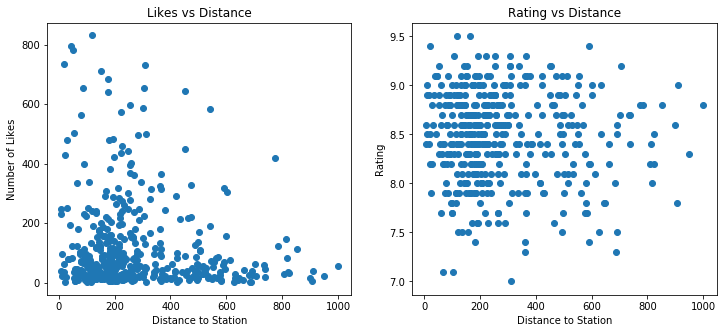

In [13]:
boston_venues = boston_venues[(boston_venues['Likes'] >= 1) & (boston_venues['Likes'] <= 1000)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(boston_venues['Distance to Station'],boston_venues['Likes'])
ax2.scatter(boston_venues['Distance to Station'],boston_venues['Rating'])
ax1.set_xlabel('Distance to Station')
ax2.set_xlabel('Distance to Station')
ax1.set_ylabel('Number of Likes')
ax2.set_ylabel('Rating')
ax1.set_title('Likes vs Distance')
ax2.set_title('Rating vs Distance')

The above plots indicate that, while ratings decrease only slightly as a function of distance, number of likes tends to drop dramatically.  We note that the likes vs distance plot exhibits significant heteroscedasticity (i.e. fluctuations depend on distance).  To tame these fluctuations, we work with the logarithm of the number of likes.  We now plot the ratings and the logarithm of likes as a function of distance, along with their best fit lines.

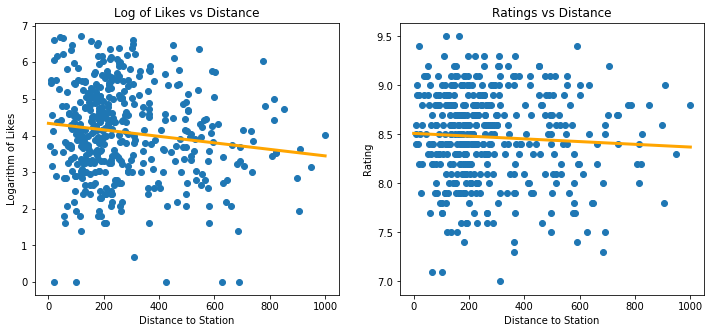

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(boston_venues['Distance to Station'],np.log(boston_venues['Likes']))
ax2.scatter(boston_venues['Distance to Station'],boston_venues['Rating'])
ax1.set_xlabel('Distance to Station')
ax2.set_xlabel('Distance to Station')
ax1.set_ylabel('Logarithm of Likes')
ax2.set_ylabel('Rating')
ax1.set_title('Log of Likes vs Distance')
ax2.set_title('Ratings vs Distance')

x = np.linspace(0, 1000, 100)

LR1 = LinearRegression()
LR1.fit(boston_venues[['Distance to Station']], np.log(boston_venues[['Likes']]))
LR2 = LinearRegression()
LR2.fit(boston_venues[['Distance to Station']], boston_venues[['Rating']])
ax1.plot(x, LR1.coef_[0] * x + LR1.intercept_[0],color='orange',linewidth=3)
ax2.plot(x, LR2.coef_[0] * x + LR2.intercept_[0],color='orange',linewidth=3)

We find that the p-value of the fit to the log-of-likes vs distance plot is about 0.0046, which indicates a high probability that the negative correlation between these quantities is significant.

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(boston_venues['Distance to Station'],
                                                               np.log(boston_venues['Likes']))
print(p_value)

0.004572542882513114


While the ratings are fairly flat as a function of distance (indicating little correlation between distance and quality), we have shown that there is significant negative correlation between distance to metro stations and number of likes.  This logic holds for the majority of venue types, with a particularly pronounced effect on certain venues, such as coffee shops.  However, there are also a few types of venues which display the opposite trend, such as hotels, which seem to increase in the number of likes as one moves away from metro stations.

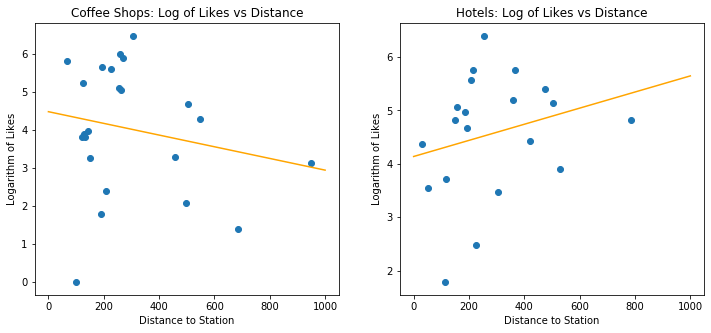

In [17]:
boston_coff = boston_venues[boston_venues['Venue Category'] == 'Coffee Shop']
boston_hotl = boston_venues[boston_venues['Venue Category'] == 'Hotel']

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(boston_coff['Distance to Station'],np.log(boston_coff['Likes']))
ax1.set_xlabel('Distance to Station')
ax1.set_ylabel('Logarithm of Likes')
ax1.set_title('Coffee Shops: Log of Likes vs Distance')
LR1 = LinearRegression()
LR1.fit(boston_coff[['Distance to Station']], np.log(boston_coff[['Likes']]))
ax1.plot(x, LR1.coef_[0] * x + LR1.intercept_[0],color='orange')

ax2.scatter(boston_hotl['Distance to Station'],np.log(boston_hotl['Likes']))
ax2.set_xlabel('Distance to Station')
ax2.set_ylabel('Logarithm of Likes')
ax2.set_title('Hotels: Log of Likes vs Distance')
LR2 = LinearRegression()
LR2.fit(boston_hotl[['Distance to Station']], np.log(boston_hotl[['Likes']]))
ax2.plot(x, LR2.coef_[0] * x + LR2.intercept_[0],color='orange')

All in all, we can conclude that, barring other information, it is advantageous for a business to be located as close to metro stations as possible.  This trend is particularly strong for food and beverage venues, such as coffee shops.  However, there are specific types of businesses, such as hotels, where this general principle may break down.  However, these exceptions to the rule are fairly small in number.